In [1]:
# to see the data distribution

from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt

def count_token_lengths(filepath, chunksize=100_000, max_tokens=50):
    counter = Counter()
    total = 0

    for chunk in pd.read_csv(filepath, usecols=["input_ids"], chunksize=chunksize):
        lengths = chunk["input_ids"].str.count(" ") + 1
        lengths = lengths[lengths <= max_tokens]  # Filter out long sequences
        counter.update(lengths)
        total += len(chunk)

    print(f"\nFinal counts by token length (≤ {max_tokens}):")
    for length in sorted(counter):
        print(f"Length {length}: {counter[length]:,}")

    lengths = list(counter.keys())
    counts = list(counter.values())

    plt.figure(figsize=(12, 6))
    plt.bar(lengths, counts)
    plt.xlabel("Token Length")
    plt.ylabel("Number of Samples")
    plt.title(f"Distribution of Token Lengths ≤ {max_tokens}")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

count_token_lengths("../data/tokenized_data_train.csv")

KeyboardInterrupt: 


Final counts by token length (≤ 30):
Length 3: 61
Length 4: 1,428
Length 5: 4,402
Length 6: 8,988
Length 7: 13,869
Length 8: 17,306
Length 9: 19,208
Length 10: 20,087
Length 11: 19,256
Length 12: 18,283
Length 13: 17,790
Length 14: 16,827
Length 15: 15,867
Length 16: 14,672
Length 17: 13,576
Length 18: 12,725
Length 19: 11,859
Length 20: 10,978
Length 21: 10,320
Length 22: 9,655
Length 23: 9,158
Length 24: 8,608
Length 25: 8,229
Length 26: 7,859
Length 27: 7,493
Length 28: 7,294
Length 29: 7,057
Length 30: 6,784


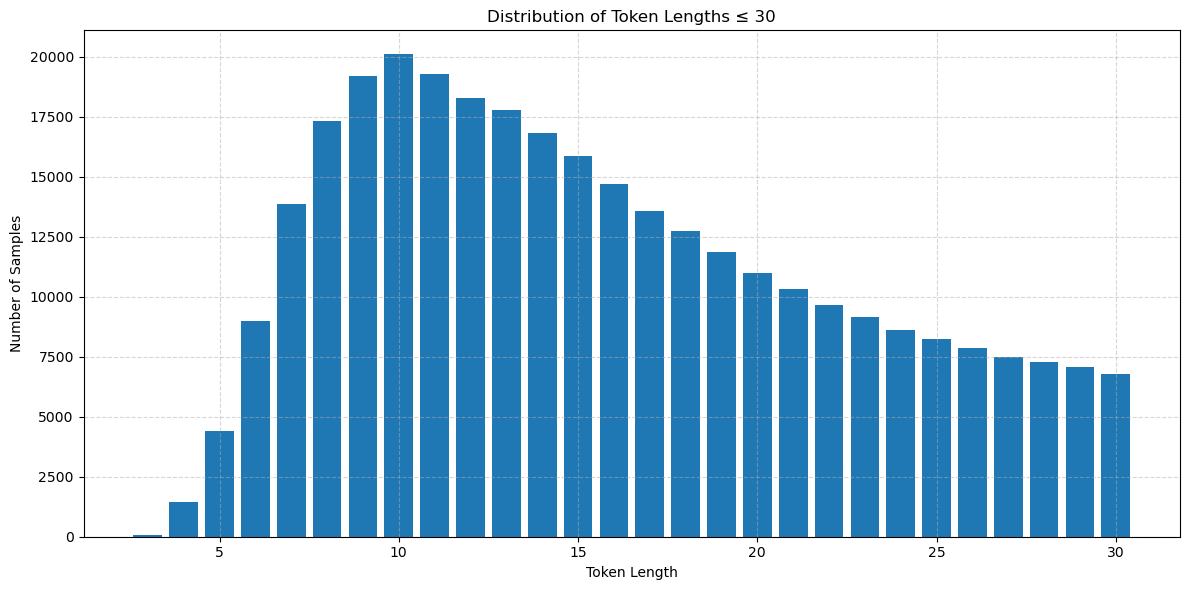

In [2]:
count_token_lengths("../data/tokenized_data_val.csv")

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset, Sampler
import tqdm
from torch.optim.lr_scheduler import LambdaLR
import math
import torch.nn.functional as F
import os, requests, json
from dotenv import load_dotenv
from datetime import datetime, timezone
import time
import sentencepiece as spm
import random
import sacrebleu
#import multiprocessing
#from transformers import get_cosine_schedule_with_warmup

In [2]:
load_dotenv()  

WEBHOOK = os.getenv("DISCORD_WEBHOOK_URL")
if not WEBHOOK:
    raise RuntimeError("Please create a .env with DISCORD_WEBHOOK_URL") # i didn't want to bother making it optional, sorry
TELEGRAM_TOKEN = os.getenv("TELEGRAM_BOT_TOKEN")
TELEGRAM_CHAT_ID = os.getenv("TELEGRAM_CHAT_ID")
if not TELEGRAM_TOKEN or not TELEGRAM_CHAT_ID:
    raise RuntimeError("Please create a .env with TELEGRAM_BOT_TOKEN and TELEGRAM_CHAT_ID") # same as above

def send_discord(content: str=None, embed: dict=None, tqdm_obj=None): # to track training progress on my phone when i'm away from my computer
    if tqdm_obj is not None:
        processed = tqdm_obj.n
        total = tqdm_obj.total
        time = tqdm_obj.format_dict["elapsed"]

        if total > 0:
            percentage = (processed / total) * 100
        else:
            percentage = 0

        content = f"Progress: {processed}/{total} ({percentage:.2f}%) \n Elapsed time: {time/60:.1f}s \n Rate: {processed / time:.2f} items/s"

    payload = {}
    if content:
        payload["content"] = content
    if embed:
        payload["embeds"] = [embed]

    headers = {"Content-Type": "application/json"}

    try:
        resp = requests.post(WEBHOOK,
                            data=json.dumps(payload),
                            headers=headers,
                            timeout=5)
        resp.raise_for_status() # check for HTTP errors
    except Exception as e:
        pass # since discord is banned in turkey (yay), i just want this to fail silently for now. maybe one day it'll start working again..


def send_telegram(content: str = None, embed: dict = None, tqdm_obj=None):
    if tqdm_obj is not None:
        processed = tqdm_obj.n
        total = tqdm_obj.total
        time = tqdm_obj.format_dict["elapsed"]

        if total > 0:
            percentage = (processed / total) * 100
        else:
            percentage = 0

        content = f"Progress: {processed}/{total} ({percentage:.2f}%) \n Elapsed time: {time/60:.1f}m \n Rate: {processed / time:.2f} items/s"

    if embed:
        lines = []
        if 'title' in embed:
            lines.append(f"<b>{embed['title']}</b>")

        for field in embed.get("fields", []):
            name = field.get("name", "")
            value = field.get("value", "")
            lines.append(f"<b>{name}:</b> {value}")

        if content:
            lines.append("")  # add a newline
            lines.append(content)

        content = "\n".join(lines)

    if not content:
        return  # nothing to send

    url = f"https://api.telegram.org/bot{TELEGRAM_TOKEN}/sendMessage"
    payload = {
        "chat_id": TELEGRAM_CHAT_ID,
        "text": content,
        "parse_mode": "HTML"
    }

    headers = {"Content-Type": "application/json"}

    try:
        resp = requests.post(url, json=payload, headers=headers, timeout=5)
        resp.raise_for_status()
    except Exception as e_direct:
        print(f"❌ Telegram error: {e_direct}")


def send_message(content: str = None, embed: dict = None, tqdm_obj=None):
    send_discord(content=content, embed=embed, tqdm_obj=tqdm_obj)
    send_telegram(content=content, embed=embed, tqdm_obj=tqdm_obj)


def make_embed(epoch, train_loss, val_loss, lr, done_steps, max_tokens, batches_per_size):
    e = {
      "title": f"Epoch {epoch} Complete 🎉",
      "color": 0x56B4E9,
      "timestamp": datetime.now(timezone.utc).isoformat(),
      "fields": [
        {"name": "Train Loss", "value": f"{train_loss:.4f}", "inline": True},
        {"name": "Val Loss",   "value": f"{val_loss:.4f}",   "inline": True},
        {"name": "LR",         "value": f"{lr:.8f}",         "inline": True},
        {"name": "Step",       "value": f"{done_steps}",     "inline": True},
        {"name": "Max Tokens", "value": f"{max_tokens}",     "inline": True},
        {"name": "Batches/Size", "value": f"{batches_per_size}", "inline": True},
      ]
    }
    return e

In [3]:
torch.set_float32_matmul_precision('high') # for better performance

In [4]:
def count_tokens_fast(s):
    return s.str.count(" ") + 1 # this is lightspeed, gamechanger for me

def parse_string(s):
    return s.str.split().apply(lambda x: np.array([int(tok) for tok in x if tok.isdigit()], dtype=np.int32))

class DatasetFromCSV(Dataset):
    def __init__(self, filepath, mode="train", batches_per_size=3000, max_tokens=15, batch_size=16):
        
        if mode == "val":
            max_tokens = 40
            batches_per_size = 500

        df = pd.read_csv(filepath, usecols=["input_ids", "label_ids"])
        df["length"] = df["input_ids"].str.count(" ") + 1
        df = df[df["length"] <= max_tokens].copy()


        df["parsed_input_ids"] = parse_string(df["input_ids"])
        df["parsed_label_ids"] = parse_string(df["label_ids"])

        max_examples_per_length = batches_per_size * batch_size

        selected_input_ids = []
        selected_label_ids = []

        for length in range(1, max_tokens + 1):
            group = df[df["length"] == length]
            if len(group) == 0:
                continue
            sampled = group.sample(n=min(len(group), max_examples_per_length))
            selected_input_ids.extend(sampled["parsed_input_ids"].tolist())
            selected_label_ids.extend(sampled["parsed_label_ids"].tolist())

        self.input_ids = selected_input_ids
        self.label_ids = selected_label_ids
        

        if mode == "train":
            print(f"[DatasetFromCSV] Loaded {len(selected_input_ids)} examples up to {max((len(seq) for seq in self.input_ids), default=0)} tokens from {min((len(seq) for seq in self.input_ids), default=0)}.")
            send_message(content=f"[DatasetFromCSV] Loaded {len(selected_input_ids)} examples up to {max((len(seq) for seq in self.input_ids), default=0)} tokens from {min((len(seq) for seq in self.input_ids), default=0)}.")


    def __getitem__(self, idx):
        return {
                "input_ids": torch.from_numpy(self.input_ids[idx]).long(),
                "label_ids": torch.from_numpy(self.label_ids[idx]).long()
        }

    def __len__(self):
        return len(self.input_ids)
    
    def get_lengths(self):
        return [len(seq) for seq in self.input_ids]

In [5]:
class BucketBatchSampler(Sampler):
    def __init__(self, lengths, batch_size=16, shuffle=True, drop_last=True, bucket_size_multiplier=100):
        self.lengths = lengths
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.drop_last = drop_last
        self.bucket_size = batch_size * bucket_size_multiplier

        self.sorted_indices = np.argsort(lengths)
        self.batches = self._create_batches()

    def _create_batches(self):
        batches = []
        for i in range(0, len(self.sorted_indices), self.bucket_size):
            bucket = self.sorted_indices[i:i+self.bucket_size]
            if self.shuffle:
                np.random.shuffle(bucket)
            for j in range(0, len(bucket), self.batch_size):
                batch = bucket[j:j+self.batch_size]
                if not self.drop_last or len(batch) == self.batch_size:
                    batches.append(batch.tolist())
        if self.shuffle:
            np.random.shuffle(batches)
        return batches

    def __iter__(self):
        yield from self.batches

    def __len__(self):
        return len(self.batches)

In [6]:
class Preprocessor:
    def __init__(self, pad_token_id=0, max_len=None):
        self.pad_token_id = pad_token_id
        self.max_len = max_len  # If None, pad to the longest in batch

    def _pad_batch(self, batch_sequences):
        input_ids = [sample['input_ids'] for sample in batch_sequences]
        label_ids = [sample['label_ids'] for sample in batch_sequences]

        input_tensor_seqs = [seq.clone().detach() for seq in input_ids]
        label_tensor_seqs = [seq.clone().detach() for seq in label_ids]

        if self.max_len:
            input_tensor_seqs = [seq[:self.max_len] for seq in input_tensor_seqs]
            label_tensor_seqs = [seq[:self.max_len] for seq in label_tensor_seqs]
        
        padded_input = pad_sequence(input_tensor_seqs, batch_first=True, padding_value=self.pad_token_id)
        padded_label = pad_sequence(label_tensor_seqs, batch_first=True, padding_value=self.pad_token_id)

        if self.max_len and padded_input.size(1) < self.max_len:
            pad_size = self.max_len - padded_input.size(1)
            pad_tensor = torch.full((padded_input.size(0), pad_size), self.pad_token_id, dtype=torch.long)
            padded_input = torch.cat([padded_input, pad_tensor], dim=1)

        if self.max_len and padded_label.size(1) < self.max_len:
            pad_size = self.max_len - padded_label.size(1)
            pad_tensor = torch.full((padded_label.size(0), pad_size), self.pad_token_id, dtype=torch.long)
            padded_label = torch.cat([padded_label, pad_tensor], dim=1)

        input_key_padding_mask = (padded_input == self.pad_token_id)  # (batch_size, seq_len)
        label_key_padding_mask = (padded_label == self.pad_token_id)

        return padded_input.contiguous(), input_key_padding_mask.contiguous(), padded_label.contiguous(), label_key_padding_mask.contiguous()

    def __call__(self, batch_sequences):
        return self._pad_batch(batch_sequences)

In [7]:
class EmbeddingLayer(nn.Module):
    def __init__(self, vocab_size, embed_dim, pad_token_id=0):
        super(EmbeddingLayer, self).__init__()

        self.token_embedding = nn.Embedding(vocab_size, embed_dim)
        self.pad_token_id = pad_token_id

        self.pos_embedding = nn.Embedding(512, embed_dim) # max length of 100 for positional encoding

    def forward(self, input_ids, key_padding_mask): # input_ids: (batch_size, seq_len)
        batch_size, seq_len = input_ids.size()
        
        token_emb = self.token_embedding(input_ids) * math.sqrt(self.token_embedding.embedding_dim) # (batch_size, seq_len, embed_dim)

        pos_emb = self.pos_embedding(torch.arange(seq_len, device=input_ids.device)).unsqueeze(0).expand(batch_size, seq_len, -1) # (batch_size, seq_len, embed_dim)

        emb = token_emb + pos_emb

        return emb

In [8]:
class EncodingLayer(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout=0.1):
        super(EncodingLayer, self).__init__()

        self.attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout, batch_first=True)

        self.layernorm1 = nn.LayerNorm(embed_dim)
        self.layernorm2 = nn.LayerNorm(embed_dim)

        self.feedforward = nn.Sequential(
            nn.Linear(embed_dim, ff_dim),
            nn.SiLU(), # using SiLU activation for better performance
            nn.Dropout(dropout),
            nn.Linear(ff_dim, embed_dim)
        )

        self.dropout = nn.Dropout(dropout)

    def forward(self, x, key_padding_mask=None):

        x_norm = self.layernorm1(x) # layernorm before attention (pre-norm)
        attn_y = self.attn(x_norm, x_norm, x_norm, key_padding_mask=key_padding_mask)[0]
        x = x + self.dropout(attn_y)


        x_norm = self.layernorm2(x) # using pre-norm for stability
        ff_output = self.feedforward(x_norm)
        x = x + self.dropout(ff_output)


        return x


In [9]:
class DecodingLayer(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout=0.1):
        super(DecodingLayer, self).__init__()

        self.attn1 = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout, batch_first=True)
        self.attn2 = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout, batch_first=True)

        self.layernorm1 = nn.LayerNorm(embed_dim)
        self.layernorm2 = nn.LayerNorm(embed_dim)
        self.layernorm3 = nn.LayerNorm(embed_dim)

        self.feedforward = nn.Sequential(
            nn.Linear(embed_dim, ff_dim),
            nn.SiLU(), # using SiLU instead of ReLU for better performance  
            nn.Dropout(dropout),
            nn.Linear(ff_dim, embed_dim)
        )

        self.dropout = nn.Dropout(dropout)

    def forward(self, x, encoder_out, tgt_key_padding_mask=None, memory_key_padding_mask=None, causal_mask=None):
        if causal_mask is None:
            seq_len = x.size(1)
            causal_mask = torch.triu(torch.ones(seq_len, seq_len, device=x.device), diagonal=1).bool()

        x_norm = self.layernorm1(x) # pre-norm on self attention
        masked_attn = self.attn1(x_norm, x_norm, x_norm, attn_mask=causal_mask, key_padding_mask=tgt_key_padding_mask)[0] # masked self attention
        x = x + self.dropout(masked_attn)


        x_norm = self.layernorm2(x) # pre-norm on cross attention
        cross_attn = self.attn2(x_norm, encoder_out, encoder_out, key_padding_mask=memory_key_padding_mask)[0]
        x = x + self.dropout(cross_attn)

        x_norm = self.layernorm3(x)
        ff_output = self.feedforward(x_norm)
        x = x + self.dropout(ff_output)

        return x

In [10]:
class Transformer(nn.Module):
    def __init__(self, vocab_size, embed_dim, ff_dim, num_heads,
                 max_seq_len=None, n_encoders=2, n_decoders=2, pad_token_id=0, dropout=0.1):
        super(Transformer, self).__init__()

        self.pad_token_id = pad_token_id

        self.src_embedding = EmbeddingLayer(vocab_size, embed_dim, pad_token_id) # embedding for source
        self.tgt_embedding = EmbeddingLayer(vocab_size, embed_dim, pad_token_id) # embedding for target

        self.encoder_layers = nn.ModuleList([ # stack of encoding layers
            EncodingLayer(embed_dim, num_heads, ff_dim, dropout)
            for _ in range(n_encoders)
        ])

        self.decoder_layers = nn.ModuleList([ # stack of decoding layers
            DecodingLayer(embed_dim, num_heads, ff_dim, dropout)
            for _ in range(n_decoders)
        ])

        self.decoder_final_norm = nn.LayerNorm(embed_dim) # final layernorm for decoder output

        self.output_projection = nn.Linear(embed_dim, vocab_size) # output layer

    def encode(self, src_ids, src_key_padding_mask):
        x = self.src_embedding(src_ids, src_key_padding_mask)
        for layer in self.encoder_layers:
            x = layer(x, key_padding_mask=src_key_padding_mask)
        return x

    def decode(self, tgt_ids, encoder_out, tgt_key_padding_mask, memory_key_padding_mask):
        x = self.tgt_embedding(tgt_ids, tgt_key_padding_mask)

        seq_len = tgt_ids.size(1)
        causal_mask = torch.triu(torch.ones(seq_len, seq_len, device=tgt_ids.device), diagonal=1).bool()

        for layer in self.decoder_layers:
            x = layer(x, encoder_out, memory_key_padding_mask=memory_key_padding_mask, tgt_key_padding_mask=tgt_key_padding_mask, causal_mask=causal_mask)

        x = self.decoder_final_norm(x) # final layernorm for decoder output
        
        return x

    def forward(self, src_ids, tgt_ids, src_key_padding_mask=None, tgt_key_padding_mask=None):
        encoder_out = self.encode(src_ids, src_key_padding_mask)
        decoder_out = self.decode(tgt_ids, encoder_out, tgt_key_padding_mask, src_key_padding_mask)
        logits = self.output_projection(decoder_out)
        return logits  # (batch_size, tgt_seq_len, vocab_size)

In [11]:
def cosine_schedule_with_plateau(warmup_steps=30000, plateau_steps=200000, total_steps=1100000, min_lr_ratio=0.001): # custom cosine schedule with plateau to fit my curriculum learning process
    def lr_lambda(current_step):
        if current_step < warmup_steps:
            return current_step / warmup_steps # warmup phase
        elif current_step < warmup_steps + plateau_steps:
            return 1.0 # plateau phase
        else:
            progress = (current_step - warmup_steps - plateau_steps) / (total_steps - warmup_steps - plateau_steps)
            cosine_decay =  0.5 * (1.0 + math.cos(math.pi * progress)) # decay, cosine annealing
            return min_lr_ratio + (1.0 - min_lr_ratio) * cosine_decay # decays down to min_lr_ratio
    return lr_lambda

In [12]:
class ModelTrainer:
    def __init__(self, model, optimizer, preprocessor, load_model_path=None, batch_size=16, device="cpu", save_path="best_model.pth", 
                 val_filepath="../data/tokenized_data_val.csv", filepath="../data/tokenized_data_train.csv", embed_dim=512,
                 max_tokens = 35, batches_per_size=3000,
                 num_warmup_steps=33000, num_plateau_steps=200000, num_training_steps=1100000, current_step=0, start_epoch=0):
        self.EOS_ID = 3 # this is the EOS token ID in my dataset
        self.PAD_ID = 0 # this is the PAD token ID in my dataset
        self.BOS_ID = 2 # this is the BOS token ID in my dataset
        
        self.max_tokens = max_tokens
        self.batches_per_size = batches_per_size
        self.batch_size = batch_size

        self.filepath=filepath
        self.model = model.to(device)
        self.start_epoch=start_epoch

        self.optimizer = optimizer
        lr_lambda = cosine_schedule_with_plateau(warmup_steps=num_warmup_steps, plateau_steps=num_plateau_steps, total_steps=num_training_steps)
        self.scheduler = LambdaLR(self.optimizer, lr_lambda)

        self.current_step = current_step 
        if current_step > 0:
            for _ in range(self.current_step):
                self.scheduler.step() # to restart the training without reinitializing the learning rate schedule
         
        self.preprocessor = preprocessor
        self.device = device
        self.save_path = save_path

        self.val_filepath = val_filepath

        self.best_val_loss = float("inf")
        self.epochs_without_improvement = 0

        self.scaler = torch.amp.GradScaler("cuda") if device == "cuda" else None

        if load_model_path:
            self.model.load_state_dict(torch.load(load_model_path, map_location=self.device))
            print(f"Model loaded from {load_model_path}")

        self.en_tokenizer = spm.SentencePieceProcessor()
        self.tr_tokenizer = spm.SentencePieceProcessor()

        self.en_tokenizer.load("../data/en_spm.model")
        self.tr_tokenizer.load("../data/tr_spm.model")


    def greedy_decode(self, input_ids, input_key_padding_mask, max_len):
        max_len = min(max_len, 50) # just in case there's some crazy sentence out there

        self.model.eval()
        with torch.no_grad():
            batch_size = input_ids.size(0)
            device = input_ids.device

            decoded = torch.full((batch_size, 1), self.BOS_ID, dtype=torch.long, device=device)
            finished = torch.zeros(batch_size, dtype=torch.bool, device=device)

            for step in range(max_len):
                logits = self.model(input_ids, decoded, src_key_padding_mask=input_key_padding_mask)
                next_token = torch.argmax(logits[:, -1, :], dim=-1, keepdim=True)
                decoded = torch.cat([decoded, next_token], dim=1)
                finished |= next_token.squeeze(1) == self.EOS_ID
                if finished.all():
                    break

            return decoded


    def decode_sequence(self, sequence, tokenizer=None):
        if tokenizer is None:
            tokenizer = self.tr_tokenizer
        tokens = []
        for tok in sequence:
            if tok == self.EOS_ID:
                break
            if tok not in {self.BOS_ID, self.PAD_ID}:
                tokens.append(tok)
        return tokenizer.decode(tokens)

    
    def compute_bleu(self, reference, hypothesis):
        return sacrebleu.sentence_bleu(hypothesis, [reference]).score
            

    def _run_epoch(self, loader, train=True):
        epoch_loss = 0.0
        num_nans = 0
        bleu_scores = []

        last_report = time.time()

        if train:
            self.model.train()
        else:
            self.model.eval()


        loader = tqdm.tqdm(loader, desc="Training" if train else "Validation", mininterval=10) # Progress bar, updating every 10 seconds to avoid cluttering the output
        for batch in loader:
            input_ids, input_key_padding_mask, label_ids, label_key_padding_mask = batch
            input_ids, input_key_padding_mask = input_ids.to(self.device, non_blocking=True), input_key_padding_mask.to(self.device, non_blocking=True)
            label_ids, label_key_padding_mask = label_ids.to(self.device, non_blocking=True), label_key_padding_mask.to(self.device, non_blocking=True)

            if input_key_padding_mask.all(dim=1).any():
                print(f"[!] Skipping batch with all-padding input sequence.")
                continue

            if label_key_padding_mask.all(dim=1).any():
                print(f"[!] Skipping batch with all-padding target sequence.")
                continue

            assert input_ids.shape == input_key_padding_mask.shape, "masking error with input_ids"
            assert label_ids.shape == label_key_padding_mask.shape, "masking error with label_ids"


            if train:
                self.optimizer.zero_grad(set_to_none=True) # zero the gradients
            
                #tgt_input = label_ids[:, :-1] # uncomment to go back to regular training
                #targets = label_ids[:, 1:] # uncomment to go back to regular training
                #tgt_key_padding_mask = label_key_padding_mask[:, :-1] # uncomment to go back to regular training

                ##################################################### EXPERIMENTAL PART #####################################################

                raw_tgt = label_ids[:, :-1].clone()                      # copy the target sequence
                eos_pos = raw_tgt == self.EOS_ID                         # find the position of the EOS token in the target sequence
                raw_tgt[eos_pos] = self.PAD_ID                           # replace the EOS token with the PAD token in the target sequence
                tgt_input = raw_tgt                                      # use the modified target sequence as input to the decoder
                targets    = label_ids[:, 1:]                            # use the original target sequence as targets for the loss function
                tgt_key_padding_mask = label_key_padding_mask[:, :-1] | eos_pos # replace the EOS token with the PAD token in the target sequence

                # why do we do this? because the model is trained to predict the EOS token, but we don't want it to see the EOS token during teacher forcing.
                # this way, it's still penalized for not predicting EOS in cross entropy loss, but it doesn't see the EOS token during teacher forcing.
                # if i didn't do this, my auxiliary loss would simply sit in a local minimum where it stops after it sees an EOS token.

                ##################################################### EXPERIMENTAL PART END #####################################################

                if self.scaler: # to use mixed precision training
                    #with torch.amp.autocast(device_type="cuda", dtype=torch.float16):
                    with torch.amp.autocast(device_type="cuda", enabled=False): # to disable in case of numerical instability
                        logits = self.model(
                            input_ids,
                            tgt_input,
                            src_key_padding_mask=input_key_padding_mask,
                            tgt_key_padding_mask=tgt_key_padding_mask
                        )
                        logits = logits.view(-1, logits.size(-1)) # only running the forward pass with autocast for now, when i add backprop it causes NaN errors

                        targets = targets.reshape(-1)

                    logits = logits.float() # convert logits to float32 for loss calculation so that float16 values don't sneak in and cause NaN errors
                    # loss = self.loss_fn(logits, targets) # this is the original line without a custom loss function

                    # below is an implementation of a loss function that doubles the loss for eos tokens, so the model is incentivized to stop at the right time.

                    losses = F.cross_entropy(logits, targets, reduction="none", ignore_index=0, label_smoothing=0.1)

                    eos_mask = (targets == self.EOS_ID).float()
                    weights = 1.0 + eos_mask  # 2 if EOS, else 1, effectively doubling the loss for EOS tokens
                    weighted_losses = losses * weights # EOS tokens get double the loss
                    loss = weighted_losses.mean() # mean loss over the batch



                    ##################################################### EXPERIMENTAL PART #####################################################

                    batch_size = input_ids.size(0)
                    logits_reshaped = logits.view(batch_size, -1, logits.size(-1))
                    eos_probs = F.softmax(logits_reshaped, dim=-1)[..., self.EOS_ID]

                    seq_len =eos_probs.size(1)
                    positions = torch.arange(seq_len, device=self.device).float().unsqueeze(0).expand(batch_size, -1)
                    true_eos_pos = (label_ids == self.EOS_ID).int().argmax(dim=1).unsqueeze(1) 

                    ramp_mask = positions < true_eos_pos # positions where the EOS probability should be getting ramped up as we approach the end of the sentence.
                    peak_mask = positions == true_eos_pos # the true EOS position
                    tail_mask = positions > true_eos_pos # tail of the output, i.e. padded positions

                    rel_diffs = (positions - true_eos_pos) / (true_eos_pos + 1e-6)

                    ramp = torch.exp(-(rel_diffs ** 2) / (2 * 0.05 ** 2)) * ramp_mask 
                    peak = peak_mask.float()
                    tail = tail_mask.float() # need exactly eos at the padded positions as well, since we don't feed EOS during teacher forcing the model constantly gets the finished sentence it needs to add EOS to.

                    target = (ramp + peak + tail) * 0.9 # because of label smoothing, the target probability is 0.9 at the correct positions, not 1.
                    target = target / (target.sum(dim=1, keepdim=True) + 1e-8) # final target distribution
                    eos_probs = eos_probs / (eos_probs.sum(dim=1, keepdim=True) + 1e-8) # the real distribution is normalized too

                    eos_loss = F.kl_div(eos_probs.log(), target, reduction='batchmean').clamp(max=10) # KL divergence calculates a differentiable loss, comparing the divergence between the two distributions

                    total_loss = eos_loss + loss
                    
                    ##################################################### EXPERIMENTAL PART END #####################################################



                    #if torch.isnan(loss).any() or torch.isinf(loss).any() or loss.item() > 1e3: unexperimental
                    if torch.isnan(total_loss).any() or torch.isinf(total_loss).any() or total_loss.item() > 1e3:
                        print(f"[!] Skipping batch with NaN/Inf/unusually large loss. Input IDs shape: {input_ids.shape}")
                        self.optimizer.zero_grad()
                        num_nans += 1
                        continue

                    #epoch_loss += loss.item()
                    epoch_loss += total_loss.item() # uncomment the above line to use the original loss function

                    main_loss = loss.item() # for logging purposes, the original loss function
                    aux_loss = eos_loss.item() # for logging purposes, the experimental loss function

                    self.scaler.scale(total_loss).backward() # Backpropagation

                    nan_grad = False
                    for name, param in self.model.named_parameters():
                        if param.grad is not None:
                            if torch.isnan(param.grad).any() or torch.isinf(param.grad).any():
                                print(f"[!] Skipping batch with NaN/Inf gradient in {name}")
                                num_nans += 1
                                
                                nan_grad = True
                                break
                    if nan_grad:
                        self.optimizer.zero_grad()
                        continue

                    if num_nans > 15:
                        send_message(content=f"Too many NaN/Inf gradients. Stopping training.")
                        raise RuntimeError("Too many NaN/Inf gradients. Stopping training.")
                    

                    self.scaler.unscale_(self.optimizer)
                    torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=0.5) # gradient clipping, since the model is fairly large

                    self.scaler.step(self.optimizer)
                    self.scaler.update()

                    self.scheduler.step()

                    loader.set_postfix(main_loss=main_loss, eos_loss=aux_loss) # Update progress bar
                    
                else:
                    logits = self.model(
                        input_ids,
                        tgt_input,
                        src_key_padding_mask=input_key_padding_mask,
                        tgt_key_padding_mask=tgt_key_padding_mask
                    )
                    logits = logits.view(-1, logits.size(-1)) 
                    targets = targets.reshape(-1)

                    losses = F.cross_entropy(logits, targets, reduction="none", ignore_index=0, label_smoothing=0.1)

                    eos_mask = (targets == self.EOS_ID).float()
                    weights = 1.0 + eos_mask  # 2 if EOS, else 1
                    weighted_losses = losses * weights # EOS tokens get double the loss
                    loss = weighted_losses.mean() # mean loss over the batch

                    epoch_loss += loss.item()

                    loss.backward() # Backpropagation
                    torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=0.5) # gradient clipping, since the model is fairly large
                    self.optimizer.step()

                    self.scheduler.step() # update learning rate each step

                    loader.set_postfix(loss=loss.item()) # Update progress bar


                now = time.time()

                if now - last_report >= 10*60: # report every 10 minutes
                    send_message(tqdm_obj=loader)
                    last_report = now
            
            else:
                with torch.no_grad():
                    tgt_input = label_ids[:, :-1]
                    targets = label_ids[:, 1:]
                    tgt_key_padding_mask = label_key_padding_mask[:, :-1]

                    logits = self.model(
                        input_ids,
                        tgt_input,
                        src_key_padding_mask=input_key_padding_mask,
                        tgt_key_padding_mask=tgt_key_padding_mask
                    )
                    logits = logits.view(-1, logits.size(-1))
                    targets = targets.reshape(-1)
                    
                    losses = F.cross_entropy(logits, targets, reduction="none", ignore_index=0, label_smoothing=0.1)

                    eos_mask = (targets == self.EOS_ID).float()
                    weights = 1.0 + eos_mask  # 2 if EOS, else 1
                    weighted_losses = losses * weights # EOS tokens get double the loss
                    loss = weighted_losses.mean() # mean loss over the batch

                    #### BLEU score calculation #####
                    if random.random() < 0.025:  # 2.5% of batches
                        max_len = (label_ids != 0).sum(dim=1).max().item()  # length cap based on label lengths
                        predictions = self.greedy_decode(input_ids, input_key_padding_mask, max_len)

                        for i in range(min(len(predictions), 3)):  # limit examples per batch
                            pred_text = self.decode_sequence(predictions[i].tolist())
                            true_text = self.decode_sequence(label_ids[i].tolist())

                            bleu = self.compute_bleu(true_text, pred_text)
                            bleu_scores.append(bleu)

                    epoch_loss += loss.item()

                loader.set_postfix(loss=loss.item())

        if len(loader) > 0:
            if not train:
                avg_bleu = sum(bleu_scores) / len(bleu_scores) if bleu_scores else 0.0
                if bleu_scores:
                    print(f"Average BLEU score this epoch: {avg_bleu:.4f}, with {len(bleu_scores)} samples.")
                    send_message(content=f"🟢 Validation BLEU: {avg_bleu:.4f} ({len(bleu_scores)} samples)")
                else:
                    print("[BLEU] No samples chosen this epoch for BLEU calculation.")
                    send_message(content="[BLEU] No samples chosen this epoch for BLEU calculation.")
            return epoch_loss / len(loader)
        else:
            return epoch_loss

    def train(self, num_epochs=50, patience=5, verbose=True):
        try:
            done_steps = self.current_step
            
            for epoch in range(self.start_epoch, num_epochs):
                if self.max_tokens + epoch <= 20:
                    max_tok = self.max_tokens + epoch
                else:
                    max_tok = min((epoch + self.max_tokens - 20)*2 + 20, 35) # faster increase after basic structures are learned
                    

                train_dataset = DatasetFromCSV(filepath=self.filepath, mode="train", 
                                               batches_per_size=self.batches_per_size,
                                               max_tokens=max_tok, # max length of 40 because my system is trash
                                               batch_size=self.batch_size
                )

                train_loader = DataLoader(
                    dataset=train_dataset,
                    batch_sampler=BucketBatchSampler(train_dataset.get_lengths(), batch_size=self.batch_size, shuffle=True),
                    collate_fn=self.preprocessor,
                    pin_memory=True
                )

                print(f"Loaded {len(train_loader)} batches of training data. Starting epoch {epoch+1}/{num_epochs}... (Current LR: {self.scheduler.get_last_lr()[0]:.8f})")
                send_message(
                    content=(
                        f"🟡 Epoch {epoch+1}/{num_epochs} started\n"
                        f"🔹 Batches: {len(train_loader)}\n"
                        f"🔹 Max Tokens: {max_tok} | Batch Size: {self.batch_size} | Batches/Size: {self.batches_per_size}\n"
                        f"🚀 LR: {self.scheduler.get_last_lr()[0]:.8f}\n"
                        f"🔁 Steps Done: {done_steps}"
                    )
                )

                train_loss = self._run_epoch(train_loader, train=True)
                done_steps += len(train_loader)

                del train_loader, train_dataset # clear the memory
                torch.cuda.empty_cache() # clear the cache to avoid OOM errors

                val_dataset = DatasetFromCSV(filepath=self.val_filepath, mode="val", batches_per_size=self.batches_per_size, batch_size=self.batch_size)

                val_loader = DataLoader(
                    dataset=val_dataset,
                    batch_sampler=BucketBatchSampler(val_dataset.get_lengths(), batch_size=self.batch_size, shuffle=True),
                    collate_fn=self.preprocessor,
                    pin_memory=True
                )

                val_loss = self._run_epoch(val_loader, train=False)

                current_lr = self.scheduler.get_last_lr()[0]
                if verbose:
                    print(f"Epoch {epoch+1}/{num_epochs}")
                    print(f"  Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Current Learning Rate: {current_lr:.8f}") 

                if val_loss < self.best_val_loss:
                    self.best_val_loss = val_loss
                    self.epochs_without_improvement = 0
                    torch.save(self.model.state_dict(), self.save_path)
                    if verbose:
                        print(f"Best model saved to {self.save_path}.")
                else:
                    self.epochs_without_improvement += 1

                if self.epochs_without_improvement >= patience:
                    if verbose:
                        print("Early stopping triggered.")
                    break

                del val_loader, val_dataset # clear the memory
                torch.cuda.empty_cache() # clear the cache to avoid OOM errors
                if verbose:
                    print(  f"🟡 Epoch {epoch+1}/{num_epochs} finished\n"
                            f"🔹 Max Tokens: {max_tok} | Batch Size: {self.batch_size} | Batches/Size: {self.batches_per_size}\n"
                            f"🚀 LR: {current_lr:.8f}\n"
                            f"🔁 Steps Done: {done_steps}"
                            f"  Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}"
                            )

                send_message(embed=make_embed(epoch+1, train_loss, val_loss, current_lr, done_steps, max_tok, self.batches_per_size))


        except KeyboardInterrupt:
            print("\nTraining interrupted by user. Saving checkpoint...")
            torch.save(self.model.state_dict(), "checkpoint.pth")
            if verbose:
                print("Checkpoint model saved.")

# pad_id=0, unk_id=1, bos_id=2, eos_id=3

In [13]:
def init_weights(self):
    for name, module in self.named_modules():
        if isinstance(module, nn.Linear):
            if name == "output_projection":
                nn.init.normal_(module.weight, mean=0, std=0.02)
            else:
                nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                nn.init.constant_(module.bias, 0)
        elif isinstance(module, nn.Embedding):
            nn.init.normal_(module.weight, mean=0, std=0.02)


In [17]:
# Starting from zero:

if __name__ == "__main__":
    preprocessor = Preprocessor(pad_token_id=0)
    model = Transformer(vocab_size=50000, n_encoders=5, n_decoders=5, embed_dim=512, ff_dim=2048, num_heads=8, dropout=0.2)
    model.apply(init_weights) # initialize weights
    optimizer = AdamW(model.parameters(), 
                    lr=0.0001,
                    weight_decay=0.01)

    trainer = ModelTrainer(
        model=model,
        optimizer=optimizer,
        preprocessor=preprocessor,
        batch_size=16, # trash gpu
        device="cuda" if torch.cuda.is_available() else "cpu",
        save_path="best_model.pth",
        max_tokens=3, # starting from a very easy point
        batches_per_size=2500, # number of batches per size
        num_training_steps=1000000, # total number of training steps
        num_warmup_steps=37500, # number of warmup steps for learning rate scheduler
        num_plateau_steps=150000, # number of plateau steps for learning rate scheduler
    )

    trainer.train(num_epochs=50, patience=25, verbose=True)

[DatasetFromCSV] Loaded 2632 examples up to 3 tokens from 3.
Loaded 164 batches of training data. Starting epoch 1/50... (Current LR: 0.00000000)


Validation: 100%|██████████| 12648/12648 [06:30<00:00, 32.40it/s, loss=7.93]


Average BLEU score this epoch: 0.0154, with 396 samples.
Epoch 1/50
  Train Loss: 11.0087, Val Loss: 7.3270, Current Learning Rate: 0.00000044
Best model saved to best_model.pth.
🟡 Epoch 1/50 finished
🔹 Max Tokens: 3 | Batch Size: 16 | Batches/Size: 2500
🚀 LR: 0.00000044
🔁 Steps Done: 164  Train Loss: 11.0087, Val Loss: 7.3270
[DatasetFromCSV] Loaded 42632 examples up to 4 tokens from 3.
Loaded 2664 batches of training data. Starting epoch 2/50... (Current LR: 0.00000044)


Validation: 100%|██████████| 12648/12648 [05:57<00:00, 35.42it/s, loss=6.81]


Average BLEU score this epoch: 1.6148, with 294 samples.
Epoch 2/50
  Train Loss: 7.1118, Val Loss: 6.3777, Current Learning Rate: 0.00000754
Best model saved to best_model.pth.
🟡 Epoch 2/50 finished
🔹 Max Tokens: 4 | Batch Size: 16 | Batches/Size: 2500
🚀 LR: 0.00000754
🔁 Steps Done: 2828  Train Loss: 7.1118, Val Loss: 6.3777
[DatasetFromCSV] Loaded 82632 examples up to 5 tokens from 3.
Loaded 5164 batches of training data. Starting epoch 3/50... (Current LR: 0.00000754)


Validation: 100%|██████████| 12648/12648 [06:45<00:00, 31.23it/s, loss=4.83]


Average BLEU score this epoch: 1.6961, with 441 samples.
Epoch 3/50
  Train Loss: 6.1656, Val Loss: 5.7435, Current Learning Rate: 0.00002131
Best model saved to best_model.pth.
🟡 Epoch 3/50 finished
🔹 Max Tokens: 5 | Batch Size: 16 | Batches/Size: 2500
🚀 LR: 0.00002131
🔁 Steps Done: 7992  Train Loss: 6.1656, Val Loss: 5.7435
[DatasetFromCSV] Loaded 122632 examples up to 6 tokens from 3.
Loaded 7664 batches of training data. Starting epoch 4/50... (Current LR: 0.00002131)


Validation: 100%|██████████| 12648/12648 [06:13<00:00, 33.86it/s, loss=5.42]


Average BLEU score this epoch: 3.0305, with 324 samples.
Epoch 4/50
  Train Loss: 5.5767, Val Loss: 5.4267, Current Learning Rate: 0.00004175
Best model saved to best_model.pth.
🟡 Epoch 4/50 finished
🔹 Max Tokens: 6 | Batch Size: 16 | Batches/Size: 2500
🚀 LR: 0.00004175
🔁 Steps Done: 15656  Train Loss: 5.5767, Val Loss: 5.4267
[DatasetFromCSV] Loaded 162632 examples up to 7 tokens from 3.
Loaded 10164 batches of training data. Starting epoch 5/50... (Current LR: 0.00004175)


Validation: 100%|██████████| 12648/12648 [06:00<00:00, 35.08it/s, loss=4.9] 


Average BLEU score this epoch: 5.8790, with 381 samples.
Epoch 5/50
  Train Loss: 4.7826, Val Loss: 5.0413, Current Learning Rate: 0.00006885
Best model saved to best_model.pth.
🟡 Epoch 5/50 finished
🔹 Max Tokens: 7 | Batch Size: 16 | Batches/Size: 2500
🚀 LR: 0.00006885
🔁 Steps Done: 25820  Train Loss: 4.7826, Val Loss: 5.0413
[DatasetFromCSV] Loaded 202632 examples up to 8 tokens from 3.
Loaded 12664 batches of training data. Starting epoch 6/50... (Current LR: 0.00006885)


Validation: 100%|██████████| 12648/12648 [06:15<00:00, 33.67it/s, loss=3.75]


Average BLEU score this epoch: 7.6645, with 342 samples.
Epoch 6/50
  Train Loss: 4.0616, Val Loss: 4.6823, Current Learning Rate: 0.00010000
Best model saved to best_model.pth.
🟡 Epoch 6/50 finished
🔹 Max Tokens: 8 | Batch Size: 16 | Batches/Size: 2500
🚀 LR: 0.00010000
🔁 Steps Done: 38484  Train Loss: 4.0616, Val Loss: 4.6823
[DatasetFromCSV] Loaded 242632 examples up to 9 tokens from 3.
Loaded 15164 batches of training data. Starting epoch 7/50... (Current LR: 0.00010000)


Validation: 100%|██████████| 12648/12648 [06:02<00:00, 34.90it/s, loss=5.71]


Average BLEU score this epoch: 7.1559, with 378 samples.
Epoch 7/50
  Train Loss: 3.6418, Val Loss: 4.4253, Current Learning Rate: 0.00010000
Best model saved to best_model.pth.
🟡 Epoch 7/50 finished
🔹 Max Tokens: 9 | Batch Size: 16 | Batches/Size: 2500
🚀 LR: 0.00010000
🔁 Steps Done: 53648  Train Loss: 3.6418, Val Loss: 4.4253
[DatasetFromCSV] Loaded 282632 examples up to 10 tokens from 3.
Loaded 17664 batches of training data. Starting epoch 8/50... (Current LR: 0.00010000)


Validation: 100%|██████████| 12648/12648 [06:02<00:00, 34.92it/s, loss=3.53]


Average BLEU score this epoch: 9.5702, with 381 samples.
Epoch 8/50
  Train Loss: 3.3848, Val Loss: 4.1459, Current Learning Rate: 0.00010000
Best model saved to best_model.pth.
🟡 Epoch 8/50 finished
🔹 Max Tokens: 10 | Batch Size: 16 | Batches/Size: 2500
🚀 LR: 0.00010000
🔁 Steps Done: 71312  Train Loss: 3.3848, Val Loss: 4.1459
[DatasetFromCSV] Loaded 322632 examples up to 11 tokens from 3.
Loaded 20164 batches of training data. Starting epoch 9/50... (Current LR: 0.00010000)


Validation: 100%|██████████| 12648/12648 [05:59<00:00, 35.17it/s, loss=3.43]


Average BLEU score this epoch: 9.2313, with 345 samples.
Epoch 9/50
  Train Loss: 3.2497, Val Loss: 3.8751, Current Learning Rate: 0.00010000
Best model saved to best_model.pth.
🟡 Epoch 9/50 finished
🔹 Max Tokens: 11 | Batch Size: 16 | Batches/Size: 2500
🚀 LR: 0.00010000
🔁 Steps Done: 91476  Train Loss: 3.2497, Val Loss: 3.8751
[DatasetFromCSV] Loaded 362632 examples up to 12 tokens from 3.
Loaded 22664 batches of training data. Starting epoch 10/50... (Current LR: 0.00010000)


Validation: 100%|██████████| 12648/12648 [05:52<00:00, 35.90it/s, loss=3.4] 


Average BLEU score this epoch: 13.6401, with 318 samples.
Epoch 10/50
  Train Loss: 3.1676, Val Loss: 3.6995, Current Learning Rate: 0.00010000
Best model saved to best_model.pth.
🟡 Epoch 10/50 finished
🔹 Max Tokens: 12 | Batch Size: 16 | Batches/Size: 2500
🚀 LR: 0.00010000
🔁 Steps Done: 114140  Train Loss: 3.1676, Val Loss: 3.6995
[DatasetFromCSV] Loaded 402632 examples up to 13 tokens from 3.
Loaded 25164 batches of training data. Starting epoch 11/50... (Current LR: 0.00010000)


Validation: 100%|██████████| 12648/12648 [06:04<00:00, 34.74it/s, loss=4.16]


Average BLEU score this epoch: 12.8229, with 360 samples.
Epoch 11/50
  Train Loss: 3.0928, Val Loss: 3.5049, Current Learning Rate: 0.00010000
Best model saved to best_model.pth.
🟡 Epoch 11/50 finished
🔹 Max Tokens: 13 | Batch Size: 16 | Batches/Size: 2500
🚀 LR: 0.00010000
🔁 Steps Done: 139304  Train Loss: 3.0928, Val Loss: 3.5049

Training interrupted by user. Saving checkpoint...
Checkpoint model saved.


In [ ]:
# To continue training the best model so far (from the end of the last completed epoch):

if __name__ == "__main__":
    preprocessor = Preprocessor(pad_token_id=0)
    model = Transformer(vocab_size=50000, n_encoders=5, n_decoders=5, embed_dim=512, ff_dim=2048, num_heads=8, dropout=0.1)
    optimizer = AdamW(model.parameters(), 
                    lr=0.0001,
                    weight_decay=0.01)

    trainer = ModelTrainer(
        model=model,
        optimizer=optimizer,
        preprocessor=preprocessor,
        batch_size=16, # trash gpu
        device="cuda" if torch.cuda.is_available() else "cpu",
        save_path="best_model.pth",
        load_model_path="best_model.pth",  # Specify the path to the saved model
        max_tokens=3, # starting point
        batches_per_size=2500, # number of batches per size
        num_training_steps=840000, # total number of training steps
        num_warmup_steps=0, # number of warmup steps for learning rate scheduler
        num_plateau_steps=40000, # number of plateau steps for learning rate scheduler
        current_step=0, # to go back to the correct optimizer state
        start_epoch=31, # specify the epoch to start from (0-indexed)
    )

    trainer.train(num_epochs=75, patience=8, verbose=True)

Model loaded from best_model.pth
[DatasetFromCSV] Loaded 1282632 examples up to 35 tokens from 3.
Loaded 80164 batches of training data. Starting epoch 32/75... (Current LR: 0.00000000)


Validation: 100%|██████████| 16021/16021 [10:04<00:00, 26.49it/s, loss=1.3]  


Average BLEU score this epoch: 27.4254, with 1152 samples.
Epoch 32/75
  Train Loss: 2.2616, Val Loss: 2.1962, Current Learning Rate: 0.00010000
Best model saved to best_model.pth.
🟡 Epoch 32/75 finished
🔹 Max Tokens: 35 | Batch Size: 16 | Batches/Size: 2500
🚀 LR: 0.00010000
🔁 Steps Done: 80164  Train Loss: 2.2616, Val Loss: 2.1962
[DatasetFromCSV] Loaded 1282632 examples up to 35 tokens from 3.
Loaded 80164 batches of training data. Starting epoch 33/75... (Current LR: 0.00010000)


Validation: 100%|██████████| 16021/16021 [10:25<00:00, 25.60it/s, loss=1.95] 


Average BLEU score this epoch: 29.0399, with 1155 samples.
Epoch 33/75
  Train Loss: 2.2545, Val Loss: 2.1831, Current Learning Rate: 0.00010000
Best model saved to best_model.pth.
🟡 Epoch 33/75 finished
🔹 Max Tokens: 35 | Batch Size: 16 | Batches/Size: 2500
🚀 LR: 0.00010000
🔁 Steps Done: 160328  Train Loss: 2.2545, Val Loss: 2.1831
[DatasetFromCSV] Loaded 1282632 examples up to 35 tokens from 3.
Loaded 80164 batches of training data. Starting epoch 34/75... (Current LR: 0.00010000)


Training:  53%|█████▎    | 42315/80164 [2:39:18<1:59:28,  5.28it/s, eos_loss=0.0645, main_loss=2.5]   

[!] Skipping batch with NaN/Inf gradient in src_embedding.token_embedding.weight


Training:  56%|█████▌    | 44988/80164 [2:48:28<1:50:32,  5.30it/s, eos_loss=0.0698, main_loss=2.61] 

[!] Skipping batch with NaN/Inf gradient in src_embedding.token_embedding.weight


Training:  57%|█████▋    | 45965/80164 [2:52:02<2:26:34,  3.89it/s, eos_loss=0.174, main_loss=2.03]  

[!] Skipping batch with NaN/Inf gradient in src_embedding.token_embedding.weight


Training:  58%|█████▊    | 46574/80164 [2:54:28<2:01:56,  4.59it/s, eos_loss=0.0708, main_loss=1.7]  

[!] Skipping batch with NaN/Inf gradient in src_embedding.token_embedding.weight


Training:  59%|█████▉    | 47267/80164 [2:57:08<1:57:35,  4.66it/s, eos_loss=0.0331, main_loss=2.31] 

[!] Skipping batch with NaN/Inf gradient in src_embedding.token_embedding.weight


Training:  59%|█████▉    | 47328/80164 [2:57:10<1:55:40,  4.73it/s, eos_loss=0.116, main_loss=3.09] 

[!] Skipping batch with NaN/Inf gradient in src_embedding.token_embedding.weight


Training:  59%|█████▉    | 47688/80164 [2:58:26<1:46:22,  5.09it/s, eos_loss=0.0602, main_loss=2.32] 

[!] Skipping batch with NaN/Inf gradient in src_embedding.token_embedding.weight


Training:  60%|█████▉    | 48042/80164 [2:59:40<1:54:18,  4.68it/s, eos_loss=0.067, main_loss=2.4]   

[!] Skipping batch with NaN/Inf gradient in src_embedding.token_embedding.weight


Training:  60%|█████▉    | 48042/80164 [2:59:44<1:54:18,  4.68it/s, eos_loss=0.0163, main_loss=1.76]

[!] Skipping batch with NaN/Inf gradient in src_embedding.token_embedding.weight


Training:  60%|██████    | 48250/80164 [3:00:27<1:55:53,  4.59it/s, eos_loss=0.0146, main_loss=1.92] 

[!] Skipping batch with NaN/Inf gradient in src_embedding.token_embedding.weight


Training:  61%|██████    | 48593/80164 [3:01:47<1:52:44,  4.67it/s, eos_loss=0.0239, main_loss=2.13] 

[!] Skipping batch with NaN/Inf gradient in src_embedding.token_embedding.weight


Training:  61%|██████    | 48747/80164 [3:02:16<1:53:06,  4.63it/s, eos_loss=0.0101, main_loss=1.28] 

[!] Skipping batch with NaN/Inf gradient in src_embedding.token_embedding.weight


Training:  61%|██████▏   | 49186/80164 [3:03:44<1:43:22,  4.99it/s, eos_loss=0.201, main_loss=2.4]   

[!] Skipping batch with NaN/Inf gradient in src_embedding.token_embedding.weight


Training:  61%|██████▏   | 49232/80164 [3:03:56<1:48:14,  4.76it/s, eos_loss=0.0554, main_loss=2.02]

[!] Skipping batch with NaN/Inf gradient in src_embedding.token_embedding.weight


Training:  61%|██████▏   | 49275/80164 [3:04:07<1:53:19,  4.54it/s, eos_loss=0.119, main_loss=1.71] 

[!] Skipping batch with NaN/Inf gradient in src_embedding.token_embedding.weight


Training:  62%|██████▏   | 49662/80164 [3:05:33<2:01:05,  4.20it/s, eos_loss=0.335, main_loss=2.25]  

[!] Skipping batch with NaN/Inf gradient in src_embedding.token_embedding.weight


Training:  62%|██████▏   | 49689/80164 [3:05:33<1:53:48,  4.46it/s, eos_loss=0.335, main_loss=2.25]


RuntimeError: Too many NaN/Inf gradients. Stopping training.

In [ ]:
# to continue from a checkpoint:

if __name__ == "__main__":
    preprocessor = Preprocessor(pad_token_id=0)
    model = Transformer(vocab_size=50000, n_encoders=5, n_decoders=5, embed_dim=512, ff_dim=2048, num_heads=8, dropout=0.1)
    optimizer = AdamW(model.parameters(), 
                    lr=0.000094,
                    weight_decay=0.01)

    trainer = ModelTrainer(
        model=model,
        optimizer=optimizer,
        preprocessor=preprocessor,
        batch_size=16,
        device="cuda" if torch.cuda.is_available() else "cpu",
        save_path="best_model.pth",
        load_model_path="checkpoint.pth",
        max_tokens=3, # starting point
        batches_per_size=2500, # number of batches per size
        num_training_steps=1850000, # total number of training steps
        num_warmup_steps=10000, # number of warmup steps for learning rate scheduler
        num_plateau_steps=1200000, # number of plateau steps for learning rate scheduler
        current_step=1150000, # to go back to the correct optimizer state
        start_epoch=30, # specify the epoch to start from (0-indexed)
    )

    trainer.train(num_epochs=70, patience=5, verbose=True)

c:\Users\takns\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


Model loaded from checkpoint.pth


: 

In [ ]:
# to test with fake data

def generate_random_sequence(min_length=3, max_length=25, vocab_size=50000):
    length = np.random.randint(min_length, max_length + 1)
    sequence = " ".join(map(str, np.random.randint(1, vocab_size, size=length)))
    return sequence

def generate_fake_data(num_examples=10000, min_length=5, max_length=20, vocab_size=50000):
    data = {
        "input_ids": ["1 " + generate_random_sequence(min_length, max_length, vocab_size) + " 2" for _ in range(num_examples)]
    }
    data["label_ids"] = [seq for seq in data["input_ids"]]
    df = pd.DataFrame(data)
    return df

fake_data = generate_fake_data(num_examples=10000, min_length=5, max_length=20, vocab_size=1000)

fake_data.to_csv("test_small.csv", index=False)



if __name__ == "__main__":
    preprocessor = Preprocessor(pad_token_id=0)
    model = Transformer(vocab_size=50000, n_encoders=4, n_decoders=4, embed_dim=512, ff_dim=2048, num_heads=8)
    optimizer = AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
    loss_fn = nn.CrossEntropyLoss(ignore_index=0)

    trainer = ModelTrainer(
        model=model,
        optimizer=optimizer,
        loss_fn=loss_fn,
        preprocessor=preprocessor,
        batch_size=32,
        device="cuda" if torch.cuda.is_available() else "cpu",
        save_path="worse_model.pth",
        val_filepath="test_small.csv", 
        filepath="test_small.csv",
        sample_frac=1
    )

    trainer.train(num_epochs=50, patience=5, verbose=True)